# Modules and Library

In [1]:
from __future__ import print_function, division
import os
import glob
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image
from torchvision import transforms, utils
from torchvision.transforms.transforms import Normalize, ToTensor
from PIL import Image
import datetime
# from uuid import uuid1
from labels import Labels


# 2. Classes

## 2.1 Prepare Dataset

In [2]:
class CustomDataset(Dataset):
    def __init__(self, root="dataset", transform=None):
        self.imagespath  = glob.glob('dataset/images/*.png') #get the image's directory, I'm familiar with glob
        self.labelspath = glob.glob('dataset/labels/*.png')  #get the label's directory, I'm familiar with glob
        self.root = root
        
        # try to print the path
        print("Img Path: ", self.imagespath)
        print("Label Path: ", self.labelspath)
        self.transform = transform
    
    def __len__(self) -> int:        
        return len(self.imagespath)
    
    def __getitem__(self,index):
        if torch.is_tensor(index):
            index = index.tolist()
        
        #load image Dataset
        img_data = self.imagespath[index]
        image = Image.open(img_data)
        
        #load label Dataset
        label_data = self.labelspath[index]
        label = Image.open(label_data)
        
        #dictionary between image and label
        sample_data = {"image":image, "label":label}
        
        if self.transform:
            sample_data = self.transform(sample_data)
        return sample_data
            
    
    def shows(self, image, label):
        for datasetIndex in range(image.shape[0]):
            image_ = ImageDenormalize()(image[datasetIndex])
            image_ = transforms.ToPILImage()(image_)
            image_ = np.asarray(image_)
            label_  = np.asarray(label[datasetIndex])
            _, axs = plt.subplots(2, figsize=(15, 15))
            axs[0].imshow(image_)
            axs[0].set_title("Image Data")
            label_ = Labels.colorize(label_)
            axs[1].imshow(label_)
            axs[1].set_title("Colorized Label")
            
            fname = datetime.datetime.now()
            print(fname)
            plt.imsave(arr=image_, fname=os.path.join("output", f"{fname}.png"))
            plt.imsave(arr=label_, fname=os.path.join("output", f"{fname}_label.png"))

## 2.2 Horizontal Flip

In [3]:
class HorizontalFlip():
    def __init__(self)-> None:
        pass
    
    def __call__(self, sample) -> dict:
        image = sample["image"]
        label = sample["label"]
        transformedImage = transforms.RandomHorizontalFlip(p=1)(image) #do a random horizontal flip (probability 1, means all image will be flipped)
        transformedLabel = transforms.RandomHorizontalFlip(p=1)(label) #do a random horizontal flip (probability 1, means all label will be flipped)
        
        return {"image":transformedImage, "label":transformedLabel}
        

## 2.3 Random Crop

In [4]:
class RandomCrop():
    def __init__(self) -> None:
            self.output_size = (512, 512)
    
    def __call__(self,sample) -> dict:
        image = sample["image"]
        label = sample["label"]

        w, h = image.size               #get image size
        new_h, new_w = self.output_size # determine new image size
        
        left = np.random.randint(0, w - new_w)  #create horizontal random location for cropping
        top = np.random.randint(0, h - new_h)   #create vertical random location for cropping
        print("image height :",h,"image weight :",w)
        print("height crop location :",top,"weight crop location :",left)
        
        imagecropped = transforms.functional.crop(image, top,left,new_h,new_w) #crop image using the defined parameter before
        labelcropped = transforms.functional.crop(label, top,left,new_h,new_w) #crop label using the same defined parameter before

        return {"image": imagecropped, "label": labelcropped} #return the results

## 2.4. Normalize

In [5]:
class ImageNormalized():
    def __init__(self) -> None:
        self.mean = (0.485, 0.456, 0.406)
        self.std = (0.229, 0.224, 0.225)
        
    def __call__(self,sample) -> dict:
        image = sample["image"]
        label = sample["label"]
        trans = transforms.Compose([
            transforms.ToTensor(),
            Normalize(self.mean, self.std)
        ])
        imageNormalized = trans(image)
        labelTensored = torch.tensor(np.asarray(label))
        
        return {"image":imageNormalized, "label":labelTensored}

## Denormalize

In [6]:
class ImageDenormalize():    
    def __init__(self) -> None:
        self.mean = (-0.485/0.229, -0.456/0.224, -0.406/0.255)
        self.std = (1/0.229, 1/0.224, 1/0.255)

    def __call__(self, sample) -> dict:
        # image = sample["image"]
        # label = sample["label"]
        trans = Normalize(self.mean, self.std)
        imagedenorm = trans(sample)
        return imagedenorm

# 3. Calling The Main

Img Path:  ['dataset/images/78_iff_12.png', 'dataset/images/udu112_st55a.png', 'dataset/images/xz_77i.png', 'dataset/images/uff_987_stw.png', 'dataset/images/a_4564.png']
Label Path:  ['dataset/labels/78_iff_12.png', 'dataset/labels/udu112_st55a.png', 'dataset/labels/xz_77i.png', 'dataset/labels/uff_987_stw.png', 'dataset/labels/a_4564.png']
image height : 1024 image weight : 2048
height crop location : 348 weight crop location : 895
0 torch.Size([1, 3, 512, 512]) torch.Size([1, 512, 512])
2021-10-17 09:34:26.741633
image height : 1024 image weight : 2048
height crop location : 232 weight crop location : 692
1 torch.Size([1, 3, 512, 512]) torch.Size([1, 512, 512])
2021-10-17 09:34:27.007991
image height : 1024 image weight : 2048
height crop location : 375 weight crop location : 935
2 torch.Size([1, 3, 512, 512]) torch.Size([1, 512, 512])
2021-10-17 09:34:27.274013
image height : 1024 image weight : 2048
height crop location : 447 weight crop location : 507
3 torch.Size([1, 3, 512, 512

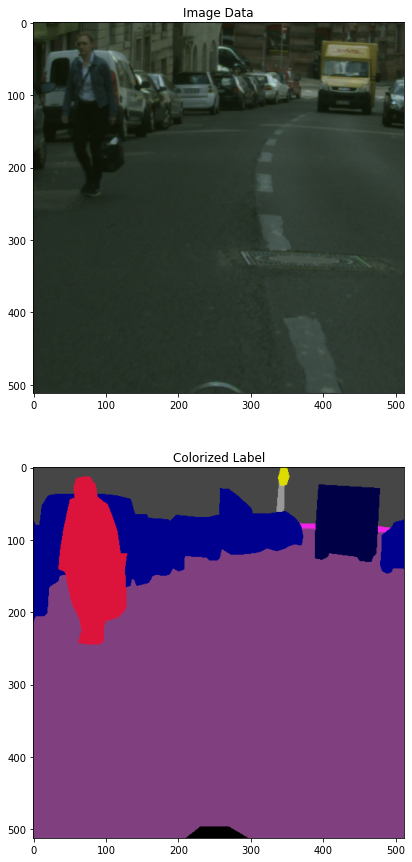

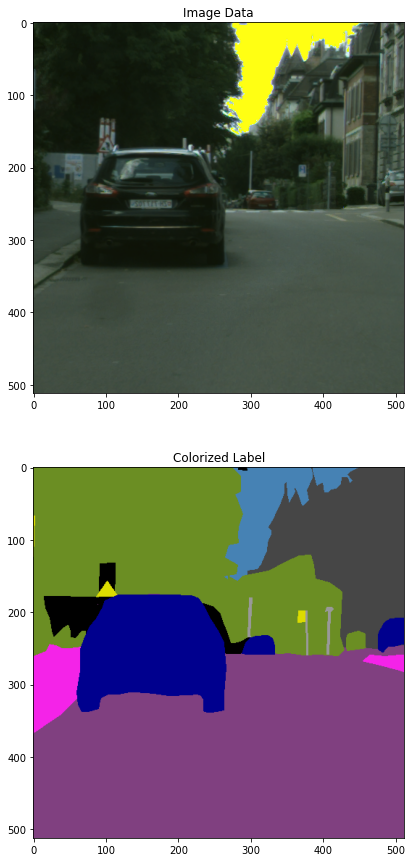

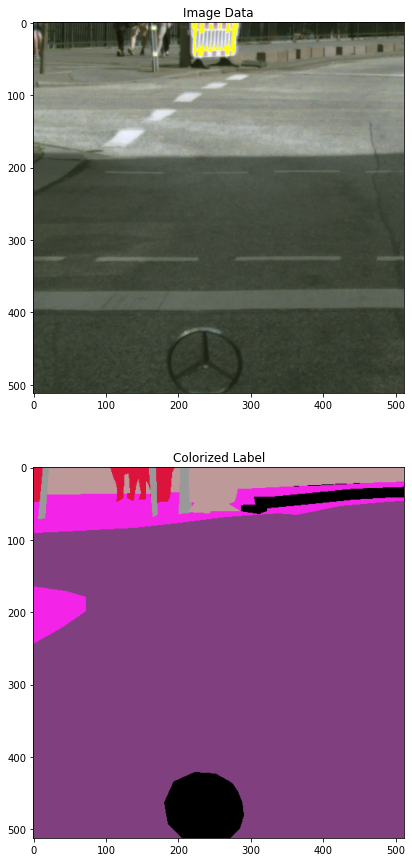

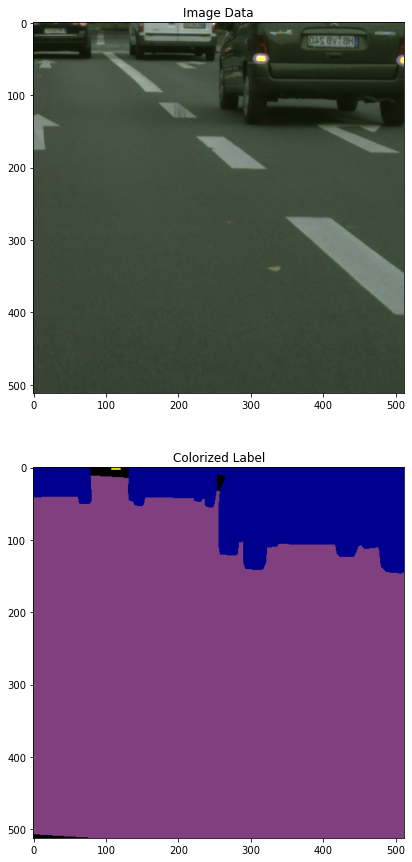

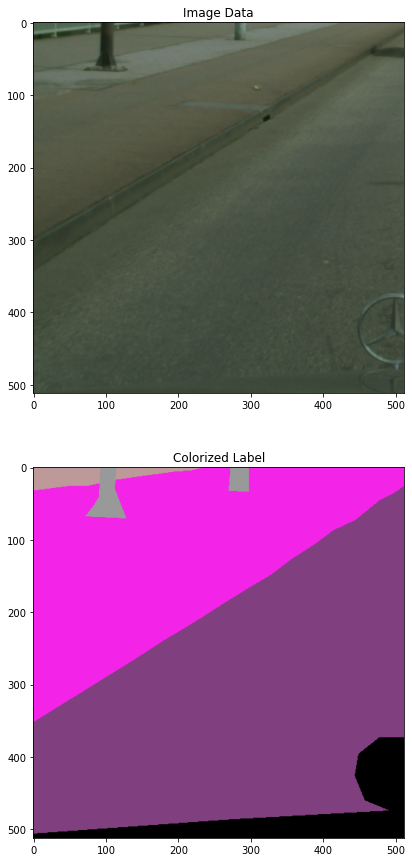

In [7]:

if __name__ == "__main__":
    alltransformation = transforms.Compose([
        RandomCrop(),HorizontalFlip(),ImageNormalized()])
    load = CustomDataset(transform = alltransformation)

    dataloader = DataLoader(load, batch_size =1, shuffle = True)
    

    # plt.imshow(transforms.ToPILImage()(trial["image"]))
    # plt.figure()
    # plt.imshow(transforms.ToPILImage()(trial["label"]))
    
    for i_batch, sample_batched in enumerate(dataloader):
        print(i_batch, sample_batched["image"].size(), sample_batched["label"].size())
        load.shows(sample_batched["image"], sample_batched["label"])
